In [31]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()
data_dir = Path('../data/processed')
data = gpd.read_file(data_dir / 'spatial_income_1880.gpkg')
# print(data.loc[data.orthodox_proportion.isna()])
data.dropna(inplace=True)

<AxesSubplot:>

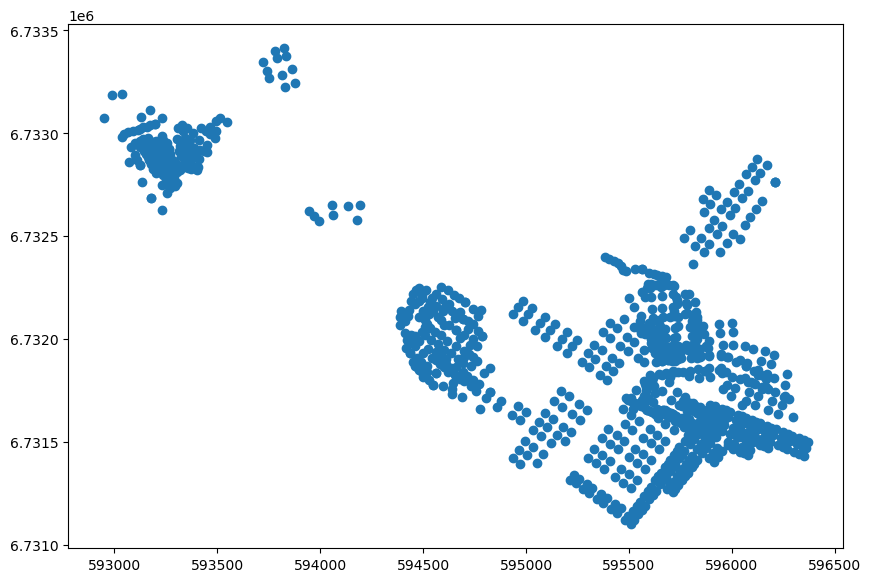

In [32]:
data.plot(figsize=(10,10))

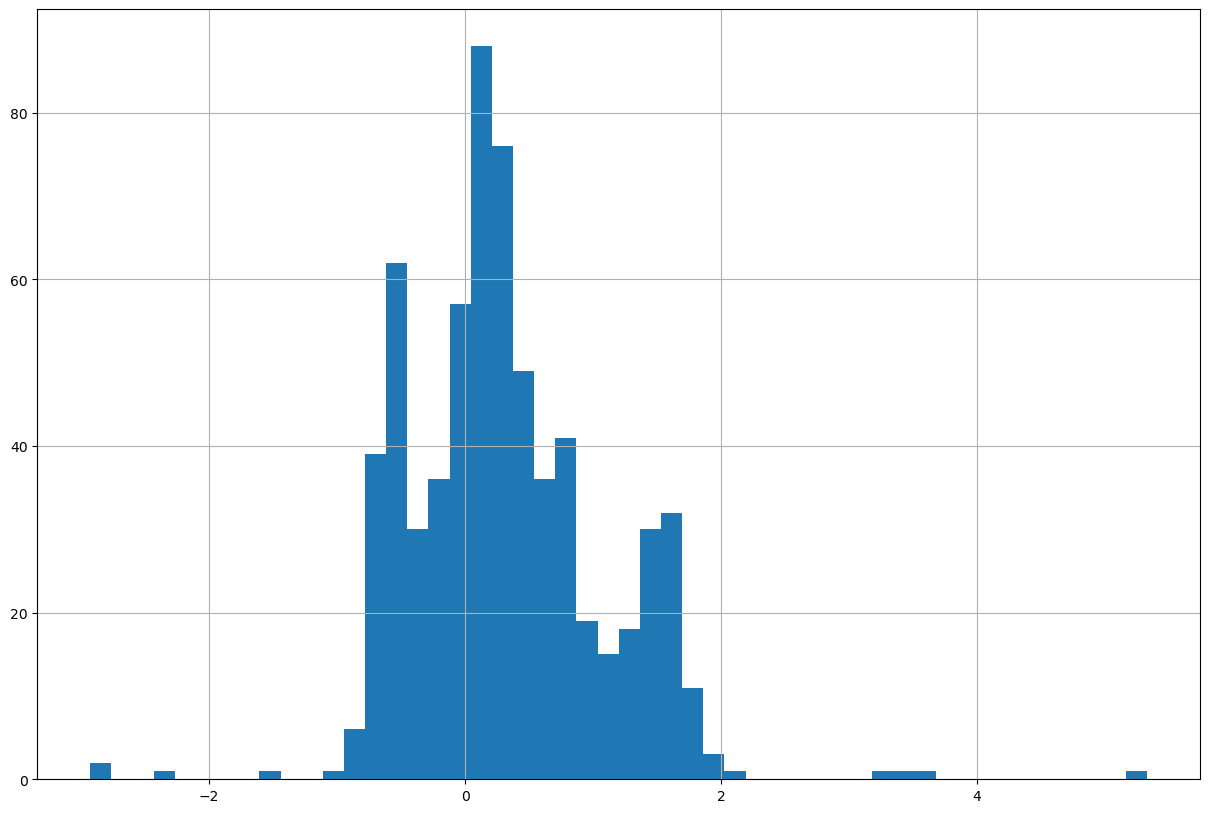

array([[<AxesSubplot:title={'center':'orthodox_proportion'}>]],
      dtype=object)

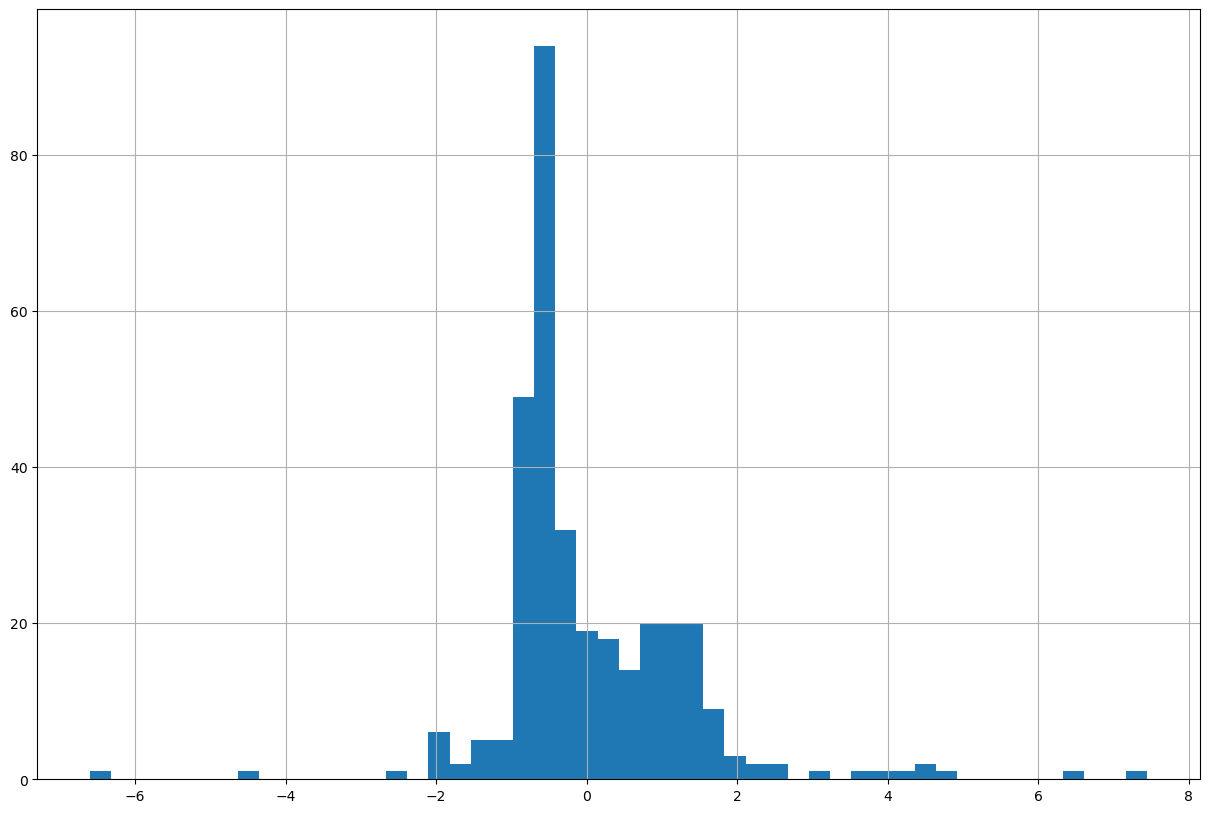

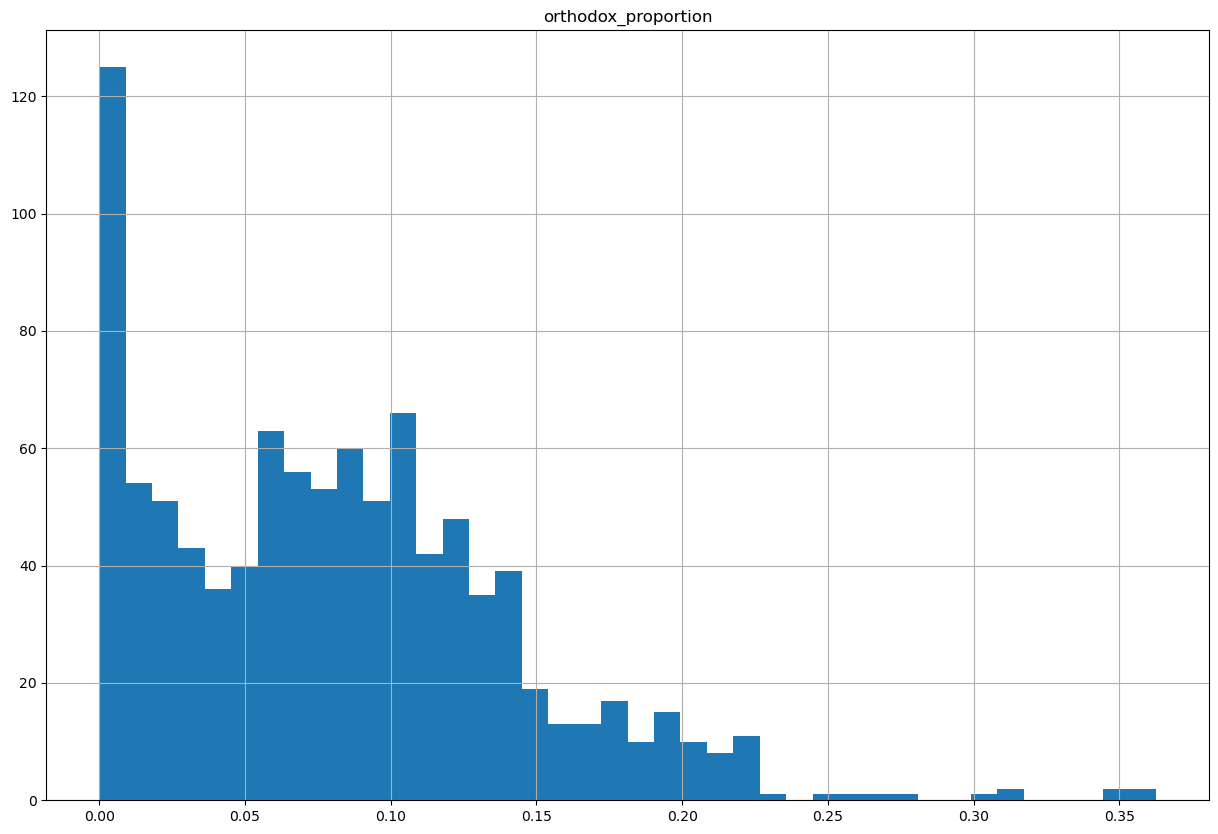

In [33]:
data.loc[data.is_old,'income_per_capita_ln'].hist(figsize=(15,10), bins=50)
plt.show()
data.loc[~data.is_old,'income_per_capita_ln'].hist(figsize=(15,10), bins=50)
data.hist(column='orthodox_proportion', figsize=(15, 10), bins=40)
# data.hist(column='orthodox')
# data.hist(column='lutheran')
# data.iplot(x='total_income', y='total_density', kind='scatter', mode='markers')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_W, sigma_W, beta_O, beta_L, sigma_O, sigma_L]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


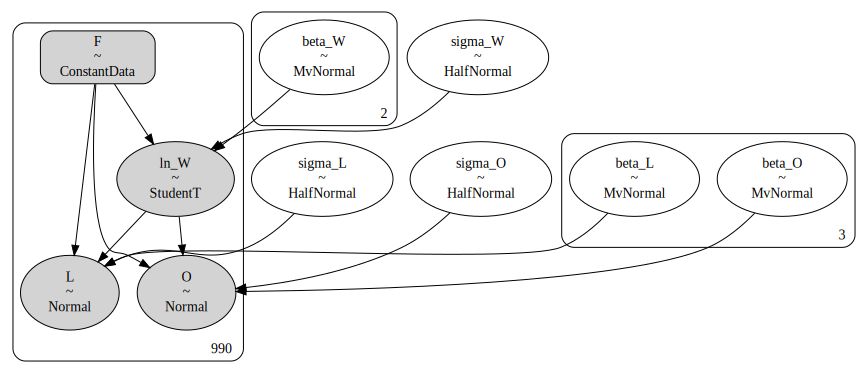

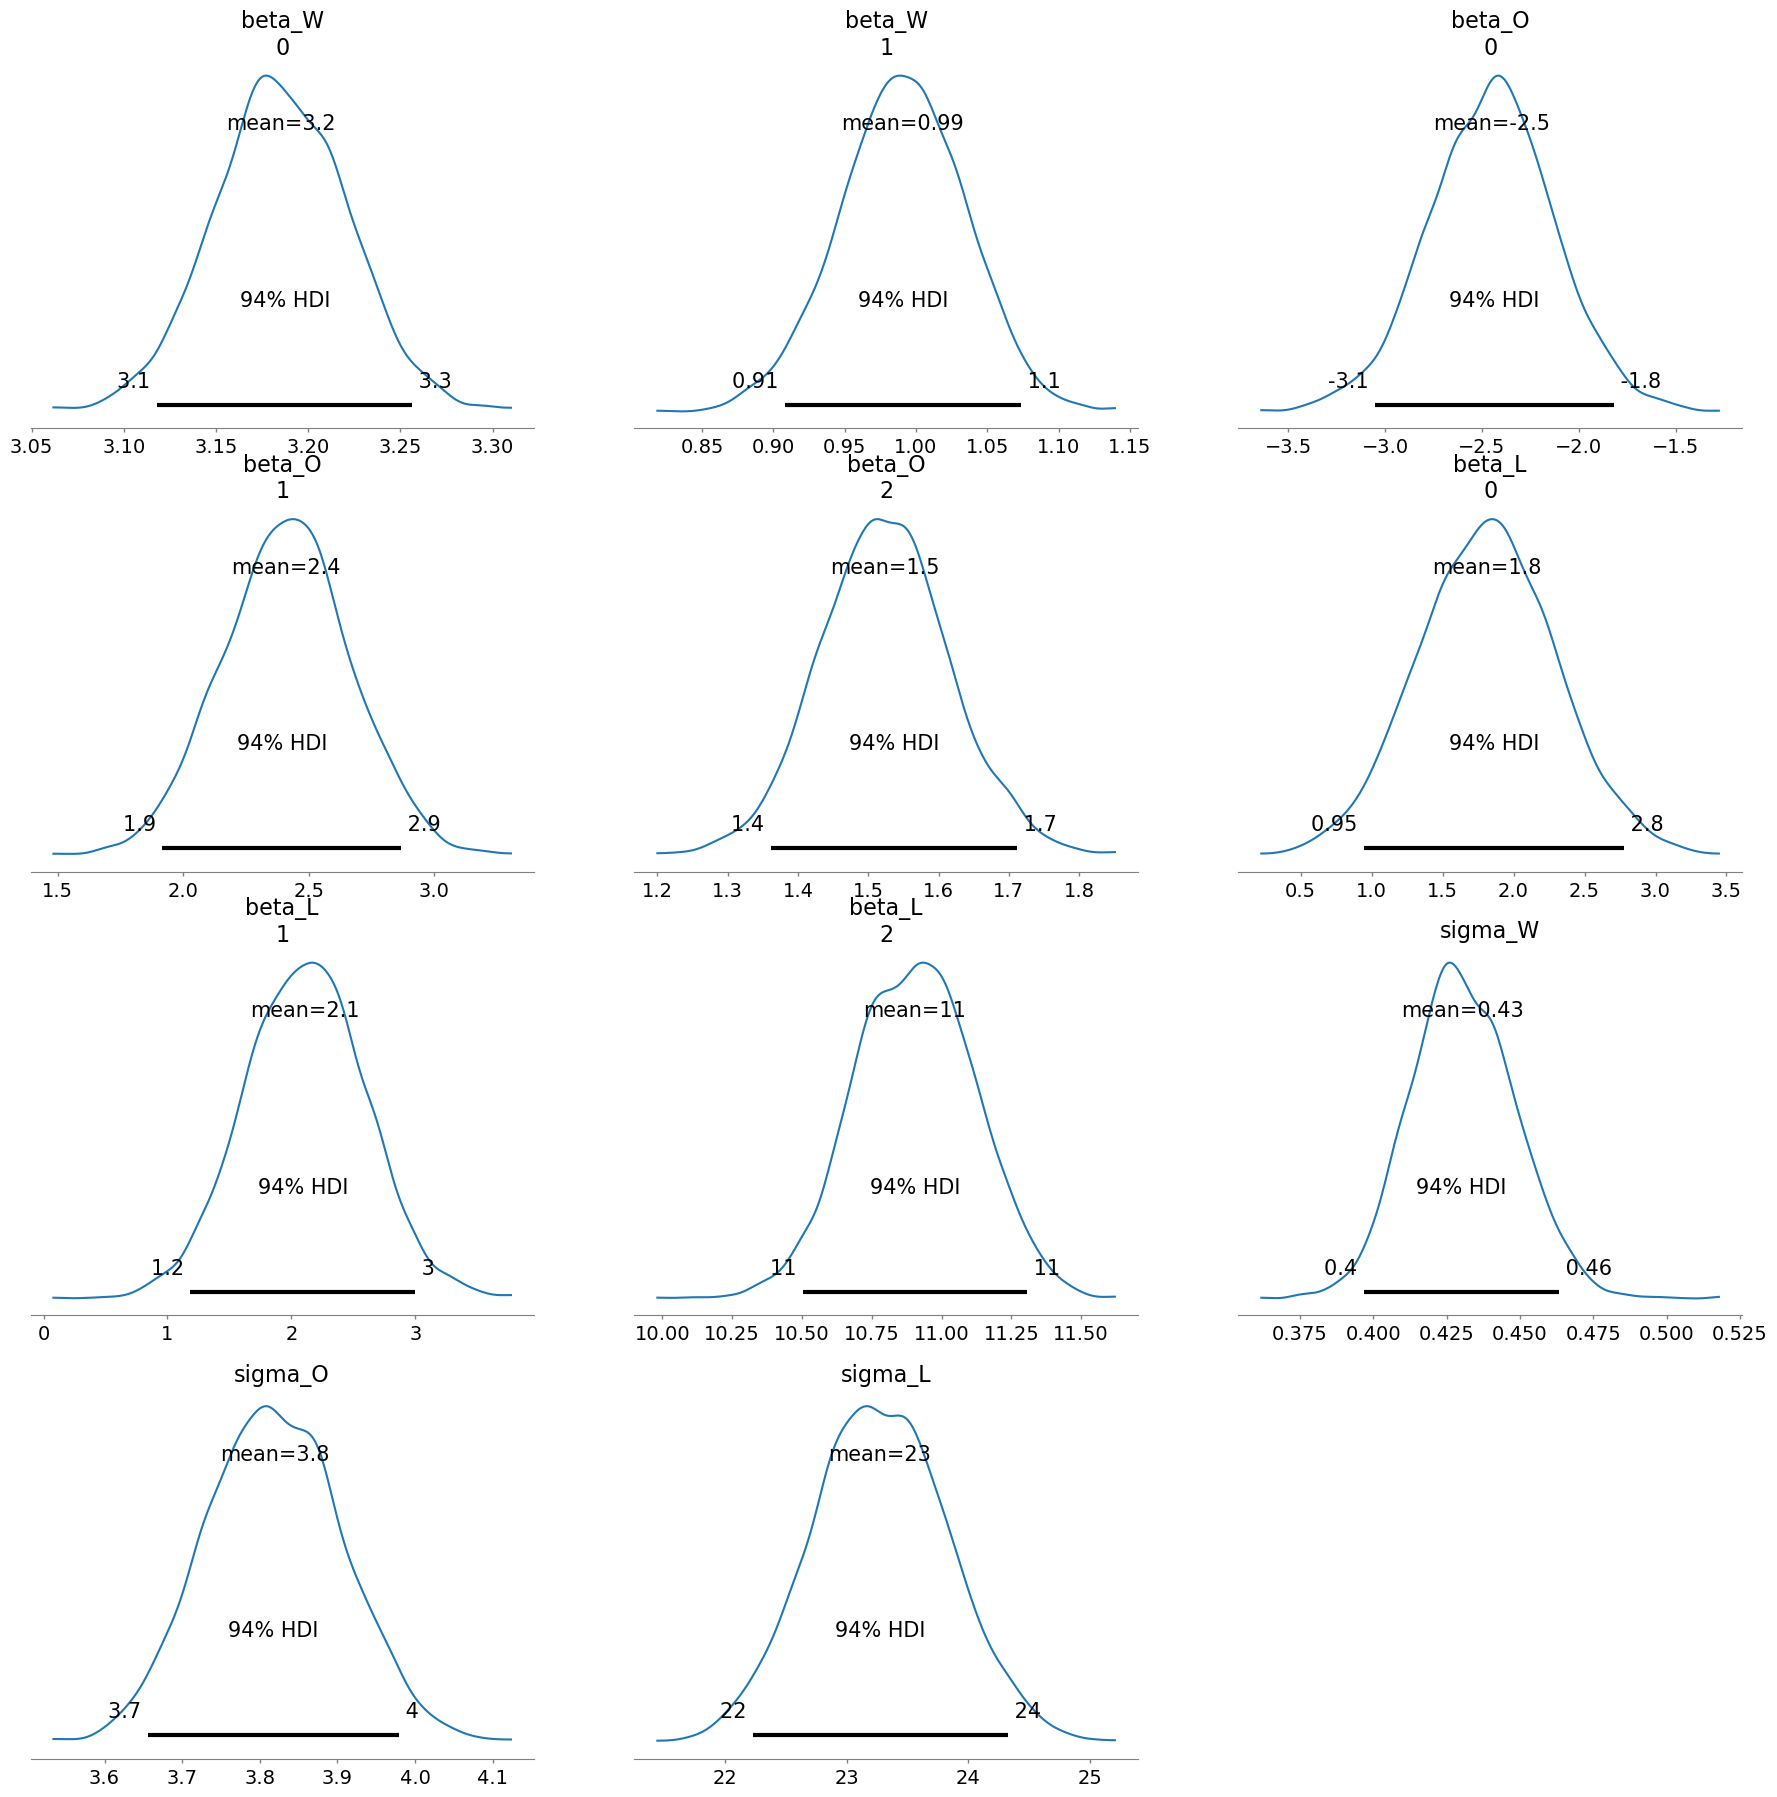

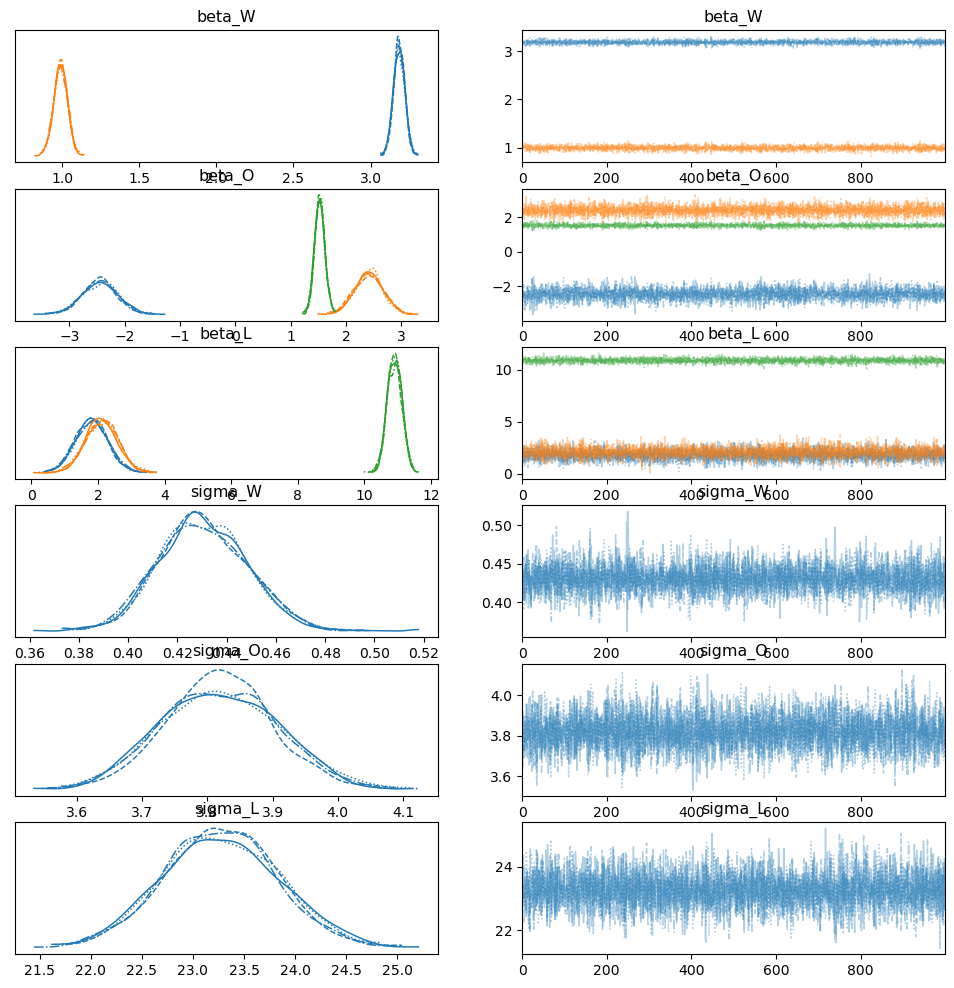

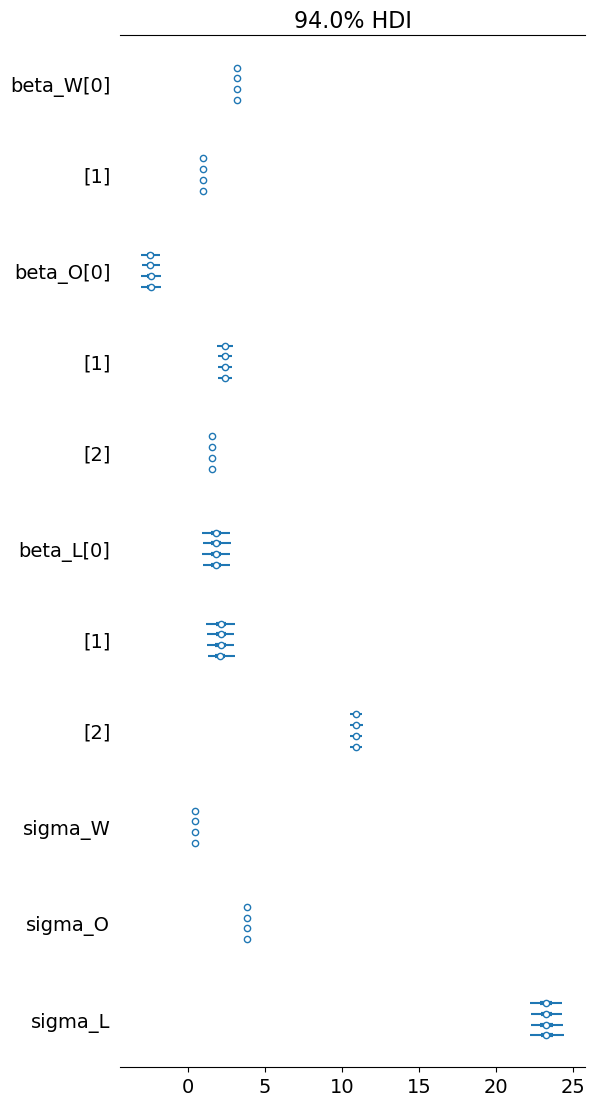

In [24]:
with pm.Model() as model_1:
    F = pm.ConstantData('F', data.is_old.astype('int'))

    mu_beta_W = np.array([4, 1])
    sigma_beta_W = np.array(np.diagflat([1, 1]))
    beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
    sigma_W = pm.HalfNormal('sigma_W', sigma=1)
    ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)

    mu_beta_O = np.array([0., 0., 0.])
    mu_beta_L = np.array([0., 0., 0.])
    sigma_beta_O = np.array(np.diagflat([0.25, 0.25, 0.25]))
    sigma_beta_L = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O = pm.MvNormal('beta_O', mu_beta_O, sigma_beta_O, shape=3)
    beta_L = pm.MvNormal('beta_L', mu_beta_L, sigma_beta_L, shape=3)
    sigma_O = pm.HalfNormal('sigma_O', 10)
    sigma_L = pm.HalfNormal('sigma_L', 10)

    O = pm.Normal('O', beta_O[0] + beta_O[1] * F + beta_O[2] * ln_W, sigma_O, observed=data.orthodox)
    L = pm.Normal('L', beta_L[0] + beta_L[1] * F + beta_L[2] * ln_W, sigma_L, observed=data.lutheran)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_W, sigma_W, beta_O_prop, beta_P, sigma_O_prop, sigma_P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The acceptance probability does not match the target. It is 0.8891, but should be close to 0.8. Try to increase the number of tuning steps.


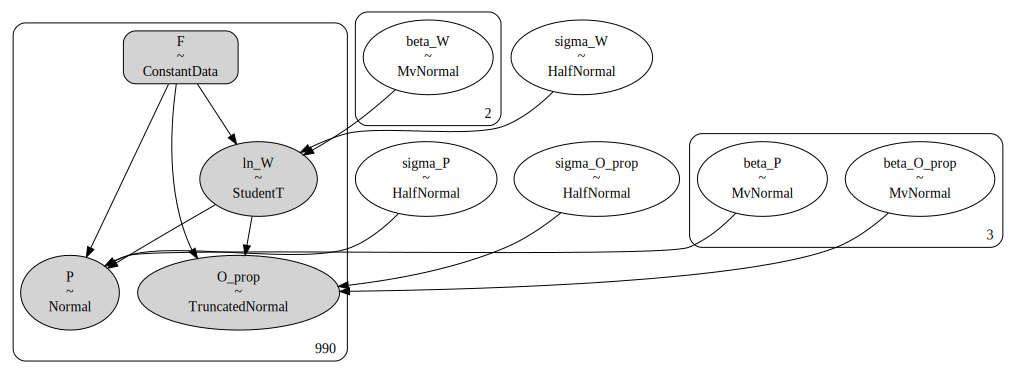

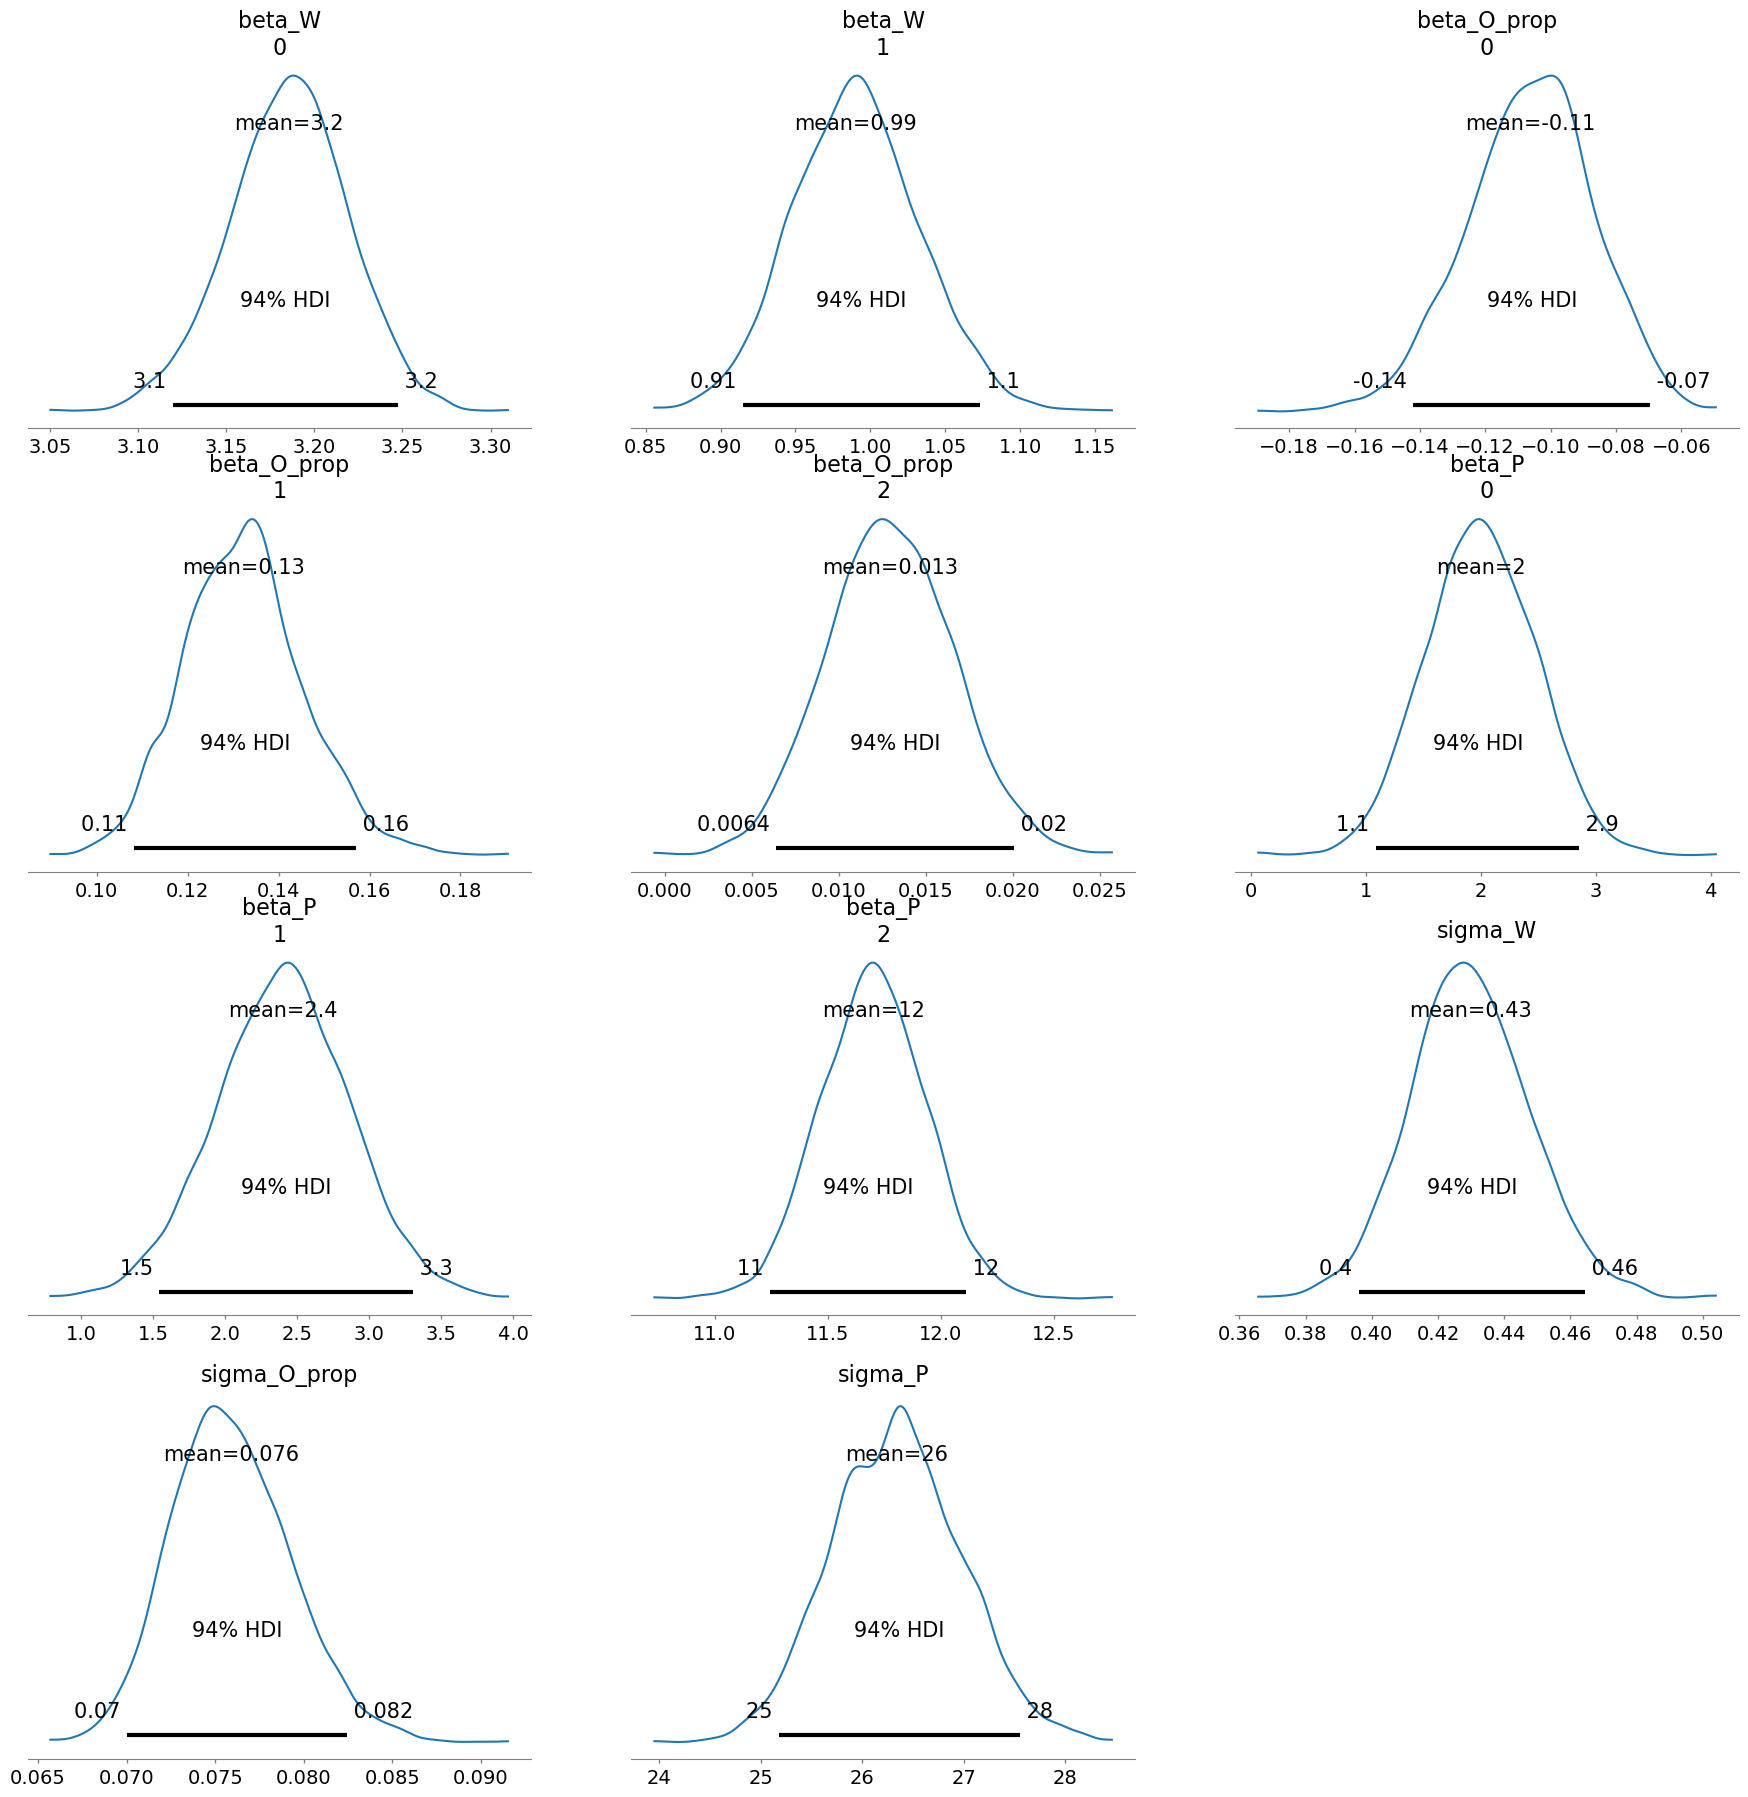

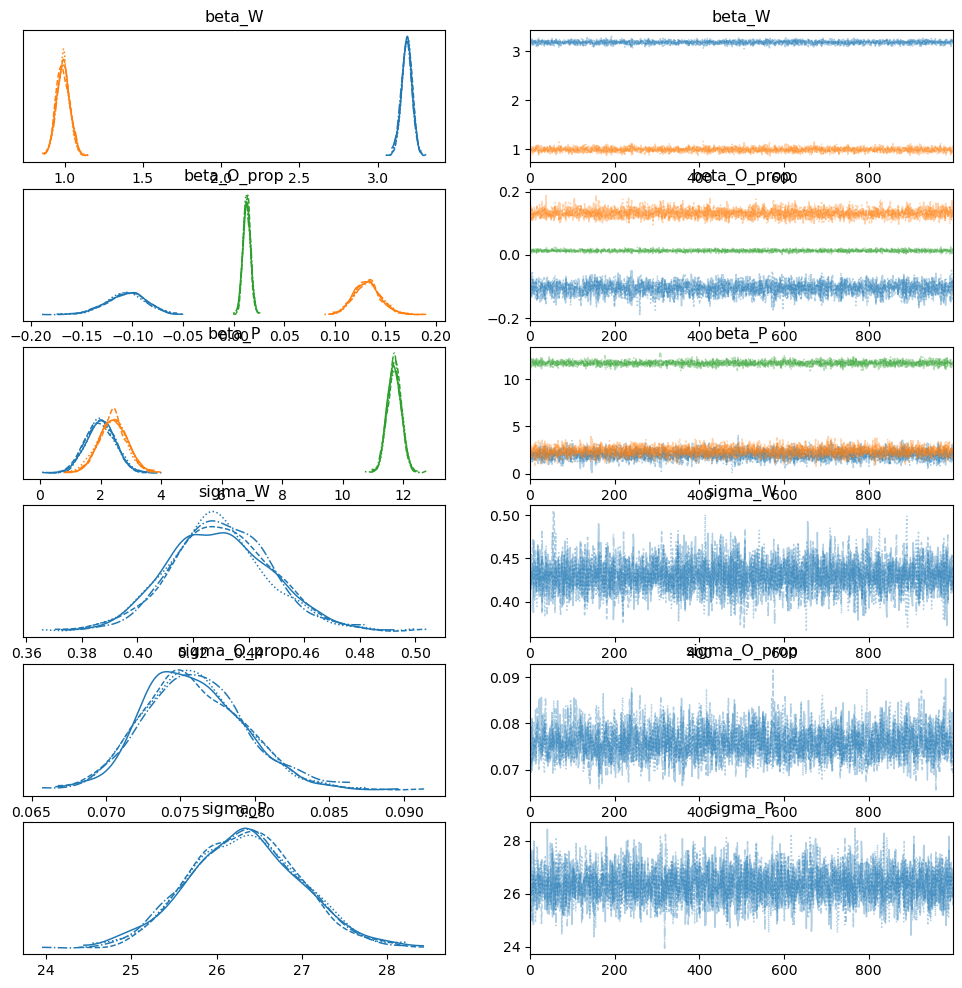

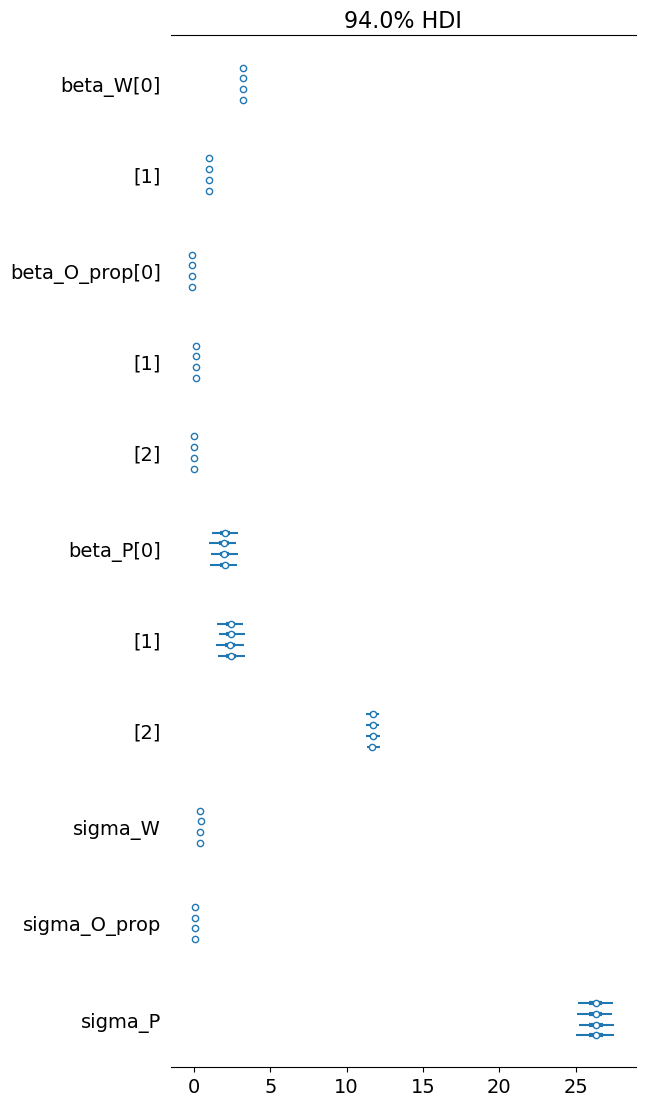

In [25]:
with pm.Model() as model_2:
    F = pm.ConstantData('F', data.is_old.astype('int'))

    mu_beta_W = np.array([4, 1])
    sigma_beta_W = np.array(np.diagflat([1, 1]))
    beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
    sigma_W = pm.HalfNormal('sigma_W', sigma=1)
    ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)

    mu_beta_O_prop = np.array([0.1, 0.1, 0.1])
    mu_beta_P = np.array([0., 0., 0.])
    sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))
    sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
    beta_P = pm.MvNormal('beta_P', mu_beta_L, sigma_beta_L, shape=3)
    sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.05)
    sigma_P = pm.HalfNormal('sigma_P', 50)
    P = pm.Normal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * ln_W, sigma_P, observed=data.population)

    mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * ln_W
    O_prop = pm.TruncatedNormal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, lower=0, upper=1, observed=data.orthodox_proportion)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_W, sigma_W, beta_O_prop, beta_P, sigma_O_prop, sigma_P, beta2_O_prop]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


array([<AxesSubplot:xlabel='ln_W / ln_W'>, <AxesSubplot:xlabel='P / P'>,
       <AxesSubplot:xlabel='O_prop / O_prop'>], dtype=object)

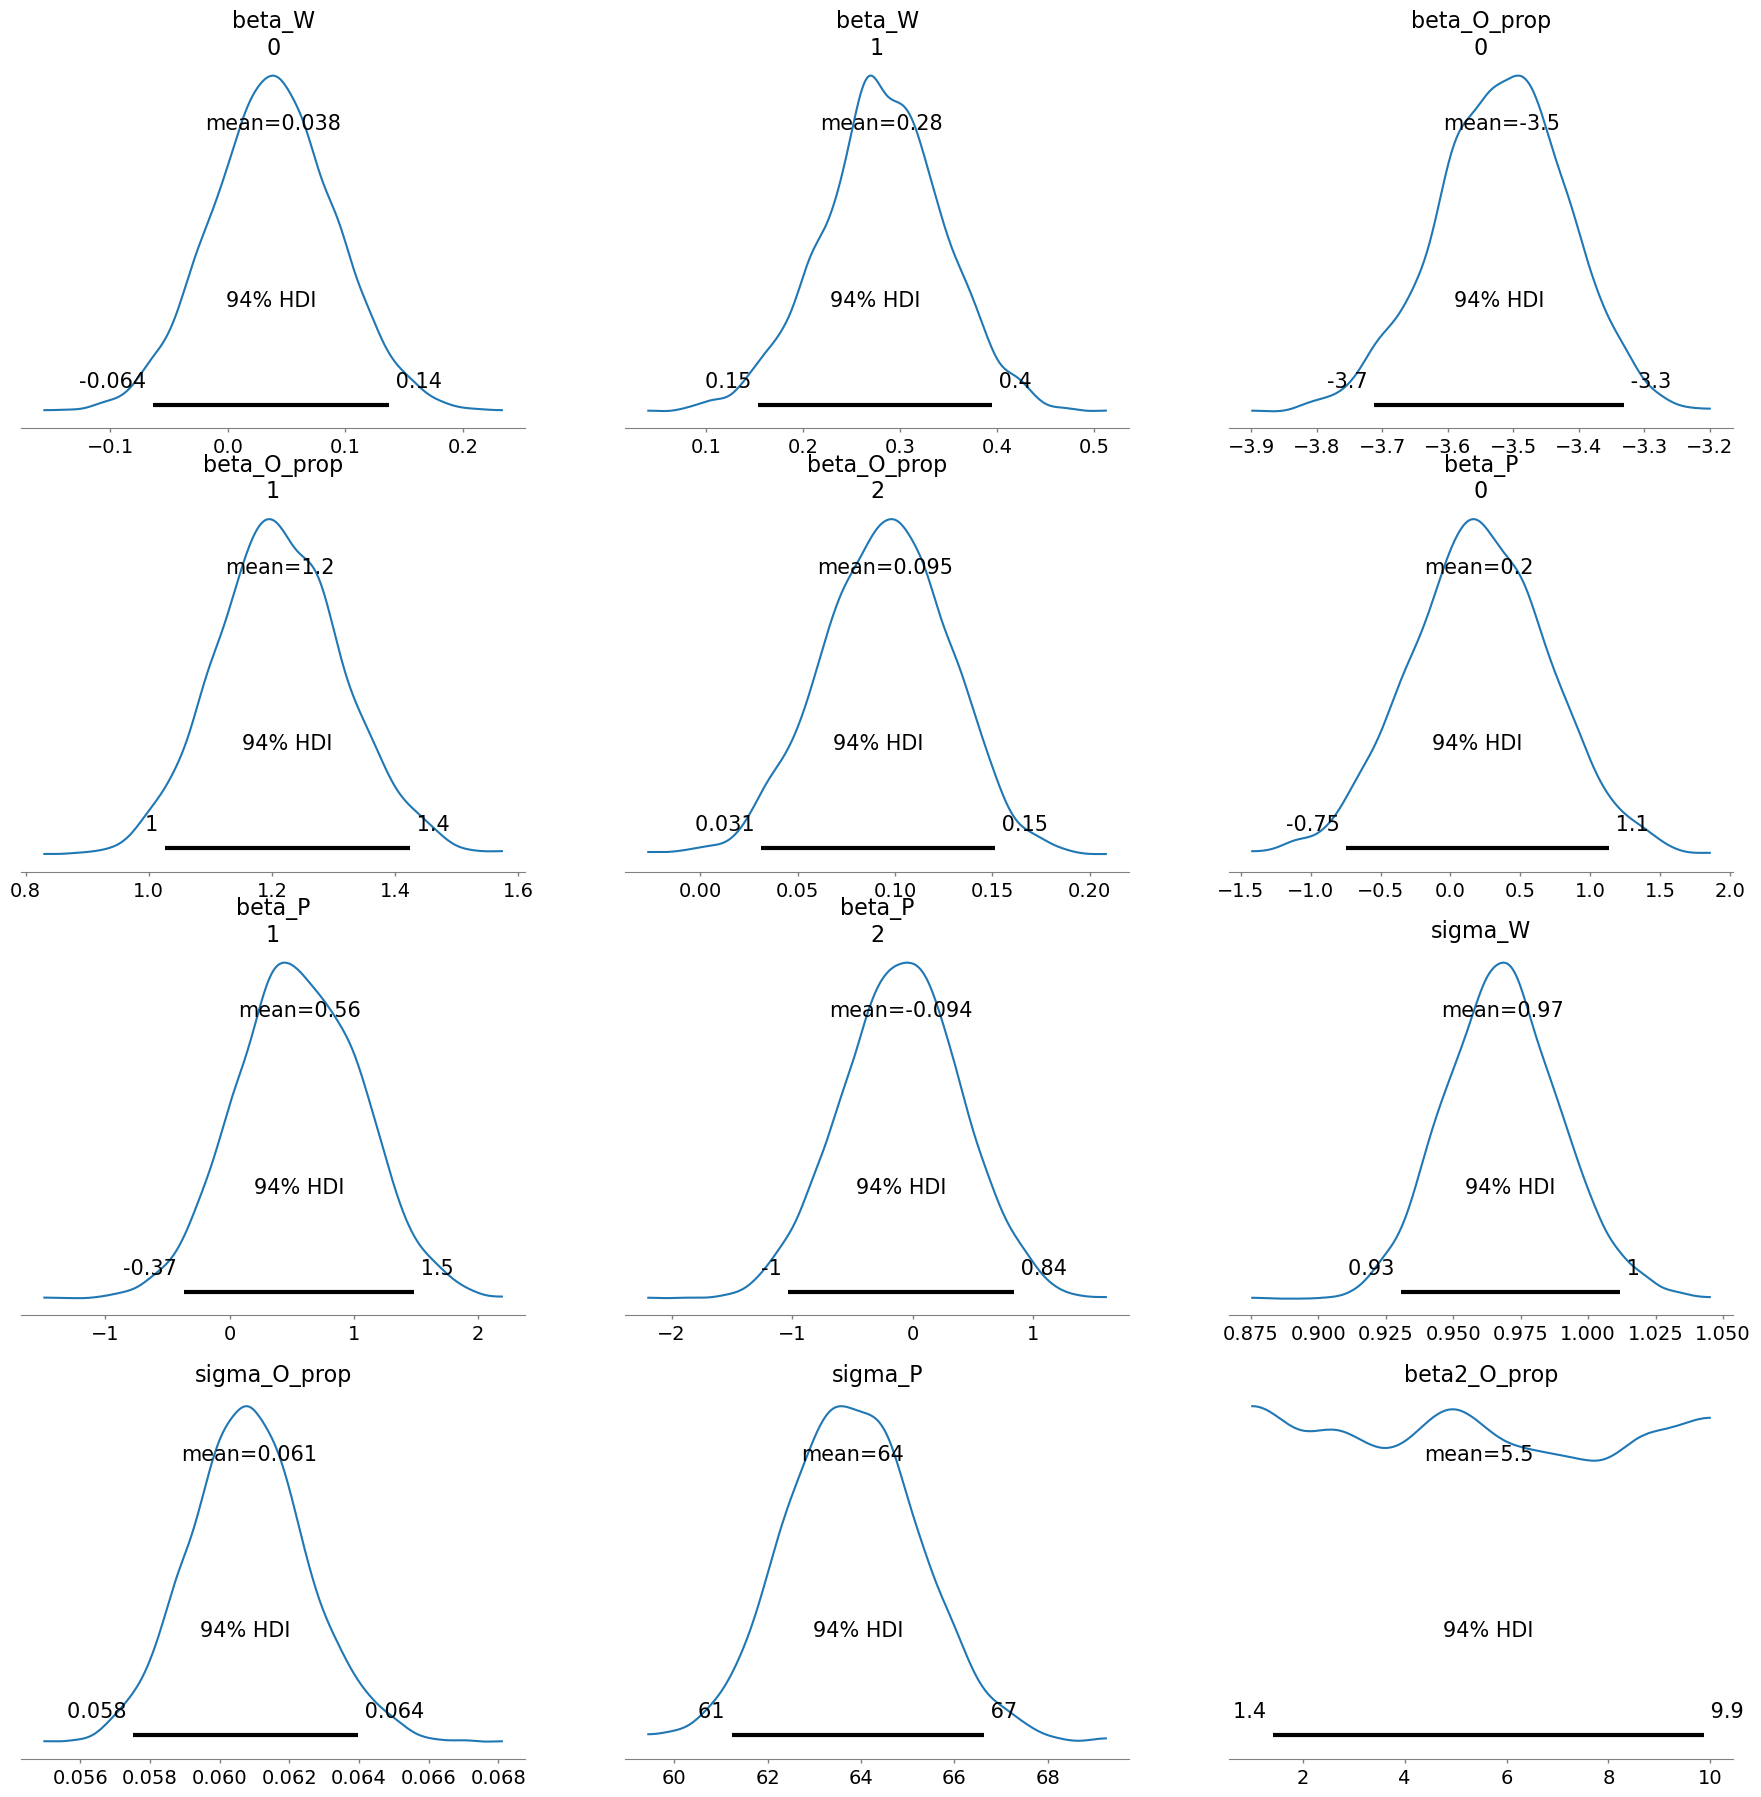

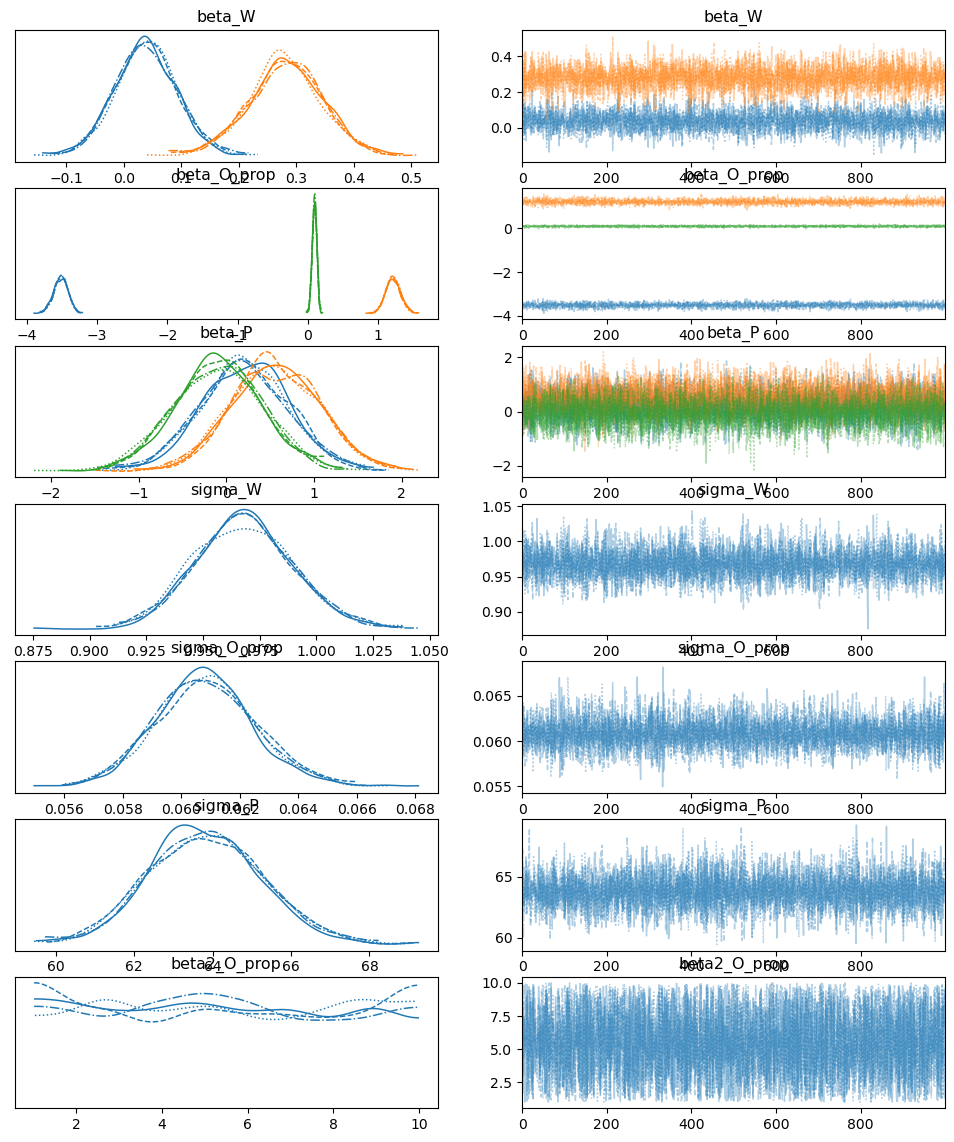

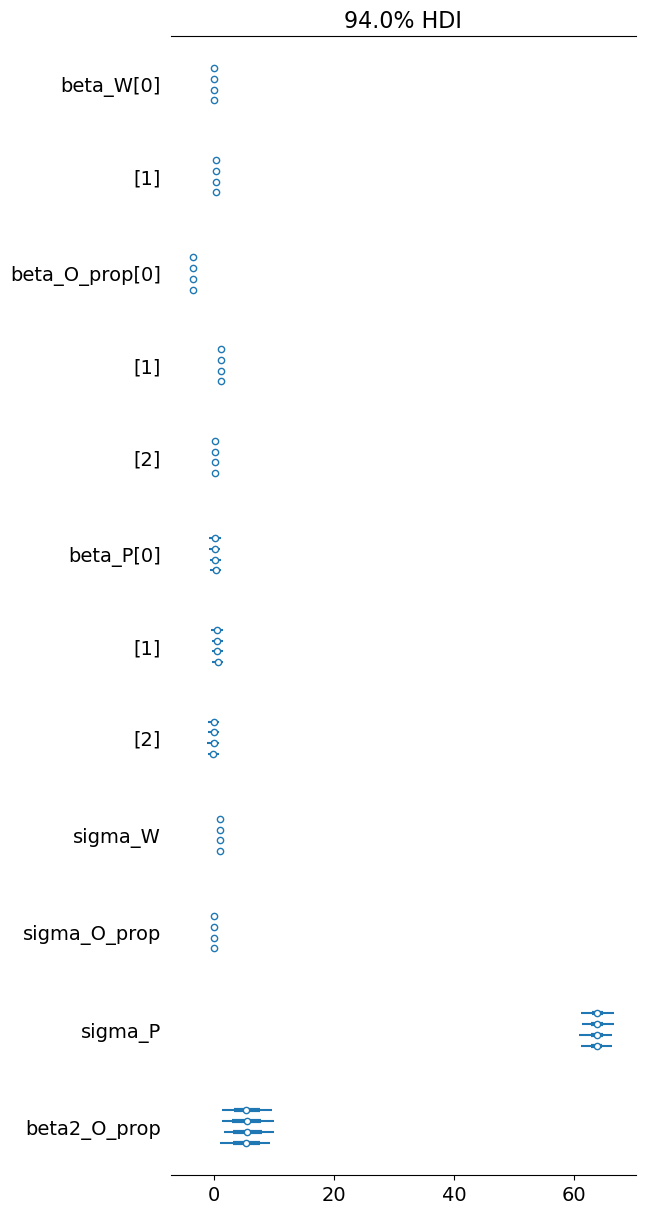

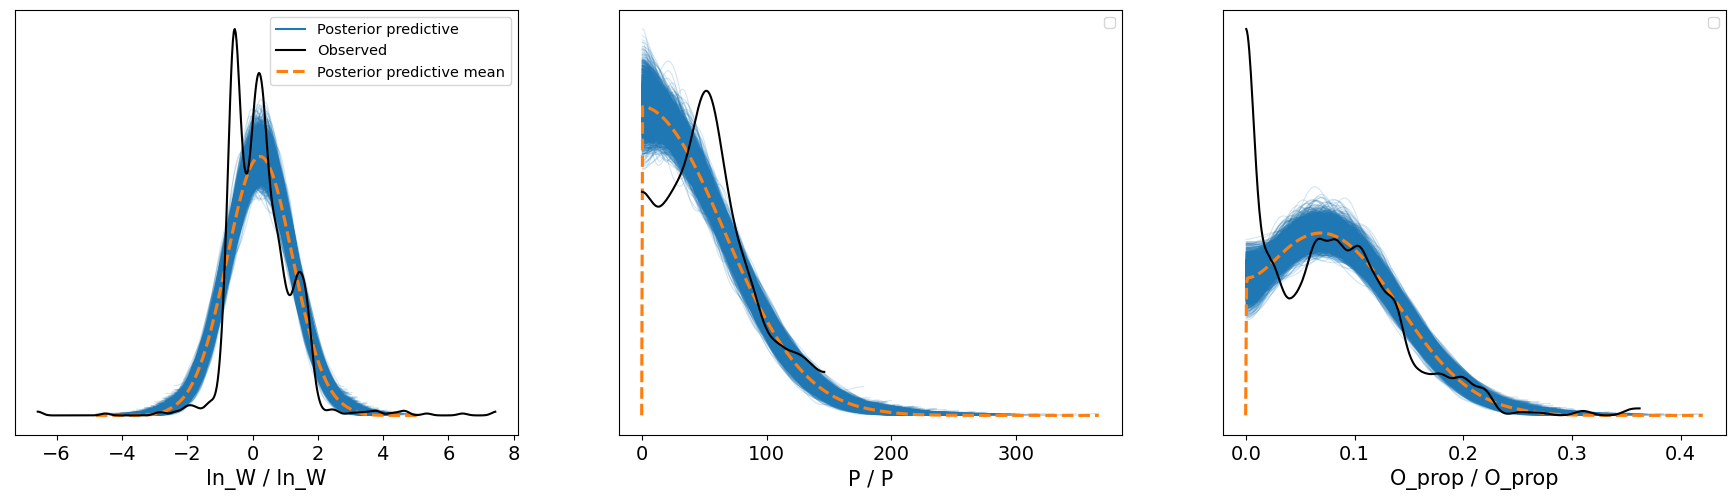

In [38]:
with pm.Model() as model_3:
    F = pm.MutableData('F', data.is_old.astype('int'))

    mu_beta_W = np.array([4, 1])
    sigma_beta_W = np.array(np.diagflat([1, 1]))
    beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
    sigma_W = pm.HalfNormal('sigma_W', sigma=1)
    ln_W = pm.TruncatedNormal('ln_W', mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, lower=-10, upper=10, observed=data.income_per_capita_ln)

    mu_beta_O_prop = np.array([1, 1, 1])
    sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))

    mu_beta_P = np.array([0., 0., 0.])
    sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
    beta_P = pm.MvNormal('beta_P', mu_beta_P, sigma_beta_P, shape=3)
    sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.01)
    sigma_P = pm.HalfNormal('sigma_P', 50)

    P = pm.TruncatedNormal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * ln_W, sigma_P, lower=0, observed=data.population)

    mu_O_prop = pm.math.invlogit(beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * ln_W)
    O_prop = pm.TruncatedNormal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, lower=0, upper=1, observed=data.orthodox_proportion)

    beta2_O_prop = pm.Uniform('beta2_O_prop', 1, 10)
    # O_prop = pm.Beta('O_prop', alpha=mu_O_prop, beta=beta2_O_prop, observed=data.orthodox_proportion)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_3)

az.plot_ppc(posterior_prediction)